In [31]:
from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
import PIL
import torch.nn as nn
import torchvision
from utils.processing import *
from utils.vnfood_ds import *
from utils.trainer import *

In [32]:
import torch, sys
print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    x = torch.rand(20000, 20000, device='cuda')
    y = x @ x
    torch.cuda.synchronize()
    print("GPU matmul OK")

Python: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Torch: 2.5.1+cu121 | CUDA build: 12.1
CUDA available: True
GPU: Quadro RTX 5000
GPU matmul OK


In [33]:
# ==== ƒê∆∞·ªùng d·∫´n d·ªØ li·ªáu ====
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"   # <== ƒë·ªïi n·∫øu c·∫ßn
root_train = f"{ROOT}/Train"
root_val   = f"{ROOT}/Validate"
root_test  = f"{ROOT}/Test"

Name_food = {0: 'Banh beo',
 1:'Banh bot loc',
 2:'Banh can',
 3:'Banh canh',
 4:'Banh chung',
 5:'Banh cuon',
 6:'Banh duc',
 7:'Banh gio',
 8:'Banh khot',
 9:'Banh mi',
 10:'Banh pia',
 11:'Banh tet',
 12:'Banh trang nuong',
 13:'Banh xeo',
 14:'Bun bo Hue',
 15:'Bun dau mam tom',
 16:'Bun mam',
 17:'Bun rieu',
 18:'Bun thit nuong',
 19:'Ca kho to',
 20:'Canh chua',
 21:'Cao lau',
 22:'Chao long',
 23:'Com tam',
 24:'Goi cuon',
 25:'Hu tieu',
 26:'Mi quang',
 27:'Nem chua',
 28:'Pho',
 29:'Xoi xeo', 
30:'banh_da_lon',
31:'banh_tieu',
32:'banh_trung_thu' 
}

In [34]:
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = getAllDataset()

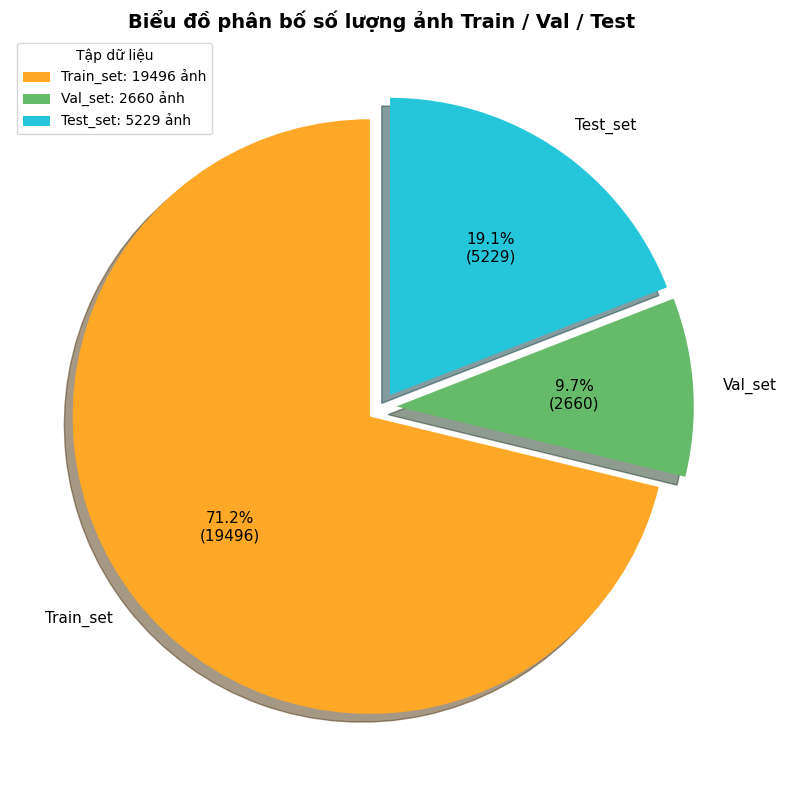

In [35]:
import matplotlib.pyplot as plt

# Gi·∫£ s·ª≠ b·∫°n ƒë√£ c√≥ c√°c bi·∫øn sau:
# train_paths, val_paths, test_paths = ...
data = {
    "Train_set": len(train_paths),
    "Val_set": len(val_paths),
    "Test_set": len(test_paths)
}

# M√†u & hi·ªáu ·ª©ng t√°ch l√°t
colors = ['#FFA726', '#66BB6A', '#26C6DA']
explode = (0.05, 0.05, 0.05)

# T·ªïng ·∫£nh
total_images = sum(data.values())

# H√†m hi·ªÉn th·ªã s·ªë l∆∞·ª£ng v√† %
def autopct_with_count(pct):
    total = total_images
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"  # hi·ªÉn th·ªã 2 d√≤ng

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(8, 8))

wedges, texts, autotexts = plt.pie(
    data.values(),
    labels=data.keys(),
    autopct=autopct_with_count,
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=90,
    textprops=dict(color="black", fontsize=11)
)

# Th√™m ti√™u ƒë·ªÅ v√† ch√∫ th√≠ch
plt.title("Bi·ªÉu ƒë·ªì ph√¢n b·ªë s·ªë l∆∞·ª£ng ·∫£nh Train / Val / Test", fontsize=14, fontweight='bold')
plt.legend(
    wedges,
    [f"{k}: {v} ·∫£nh" for k, v in data.items()],
    title="T·∫≠p d·ªØ li·ªáu",
    loc="best"
)
plt.tight_layout()
plt.show()

In [36]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_labels = lb.fit_transform(train_labels)
val_labels = lb.fit_transform(val_labels)
test_labels = lb.fit_transform(test_labels)

In [37]:
train_labels = np.eye(33)[train_labels]
val_labels = np.eye(33)[val_labels]
test_labels = np.eye(33)[test_labels]
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} images)".format(pct, absolute)

In [38]:
import pandas as pd
def plot_compare_distributions(array1, array2, array3, food_name, title1='Train images distribution', title2='', title3 = '' ):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array3 = pd.DataFrame()
    df_array1['food_name'] = array1.argmax(axis=1)
    df_array2['food_name'] = array2.argmax(axis=1)
    df_array3['food_name'] = array3.argmax(axis=1)
    highlight =(0.05,0.05,0.05, 0.05)
    fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharey=False)
    x = food_name.values()
    colors = ['orange', 'green', 'cyan', "red"]

    y = df_array1['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[1].set_title(title2)
    axs[1].grid()
    
    y = df_array3['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[2].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[2].set_title(title3)
    axs[2].grid()
    plt.show()

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

def _counts_from_logits(arr, n_classes: int):
    """arr: (N, C) logits/probs ho·∫∑c (N,) labels int.
       Tr·∫£ v·ªÅ Series ƒë·ªô d√†i C, ƒë·ªß m·ªçi l·ªõp (fill 0 n·∫øu thi·∫øu)."""
    if arr.ndim == 2:  # (N, C) -> l·∫•y argmax
        labels = arr.argmax(axis=1)
    else:              # (N,) ƒë√£ l√† label
        labels = arr
    s = pd.Series(labels).value_counts().sort_index()
    return s.reindex(range(n_classes), fill_value=0)

def _names_from_mapping(name_food: dict):
    """Tr·∫£ v·ªÅ list t√™n l·ªõp theo th·ª© t·ª± id tƒÉng d·∫ßn."""
    return [name for name, idx in sorted(name_food.items(), key=lambda kv: kv[1])]

def _autopct(values):
    total = float(values.sum())
    def fmt(pct):
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return fmt

def plot_compare_distributions(array1, array2, array3, name_food: dict,
                               title1='Ph√¢n ph·ªëi d·ªØ li·ªáu t·∫≠p hu·∫•n luy·ªán',
                               title2='Ph√¢n ph·ªëi d·ªØ li·ªáu t·∫≠p ƒë√°nh gi√°',
                               title3='Ph√¢n ph·ªëi d·ªØ li·ªáu t·∫≠p ki·ªÉm tra'):
    n_classes = len(name_food)
    labels = _names_from_mapping(name_food)

    # ƒê·∫øm t·ª´ng split
    import numpy as np  # th√™m tr√™n ƒë·∫ßu file

    y1 = _counts_from_logits(np.asarray(array1), n_classes)
    y2 = _counts_from_logits(np.asarray(array2), n_classes)
    y3 = _counts_from_logits(np.asarray(array3), n_classes)

    # explode & colors kh·ªõp s·ªë l·ªõp
    explode = [0.05] * n_classes
    # Gh√©p nhi·ªÅu b·∫£ng m√†u cho ƒë·ªß 30+ m√†u
    palette = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)
    colors = palette[:n_classes]

    fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharey=False)

    axs[0].pie(y1.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y1.values), shadow=True)
    axs[0].set_title(title1); axs[0].grid()

    axs[1].pie(y2.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y2.values), shadow=True)
    axs[1].set_title(title2); axs[1].grid()

    axs[2].pie(y3.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y3.values), shadow=True)
    axs[2].set_title(title3); axs[2].grid()

    plt.tight_layout()
    plt.show()

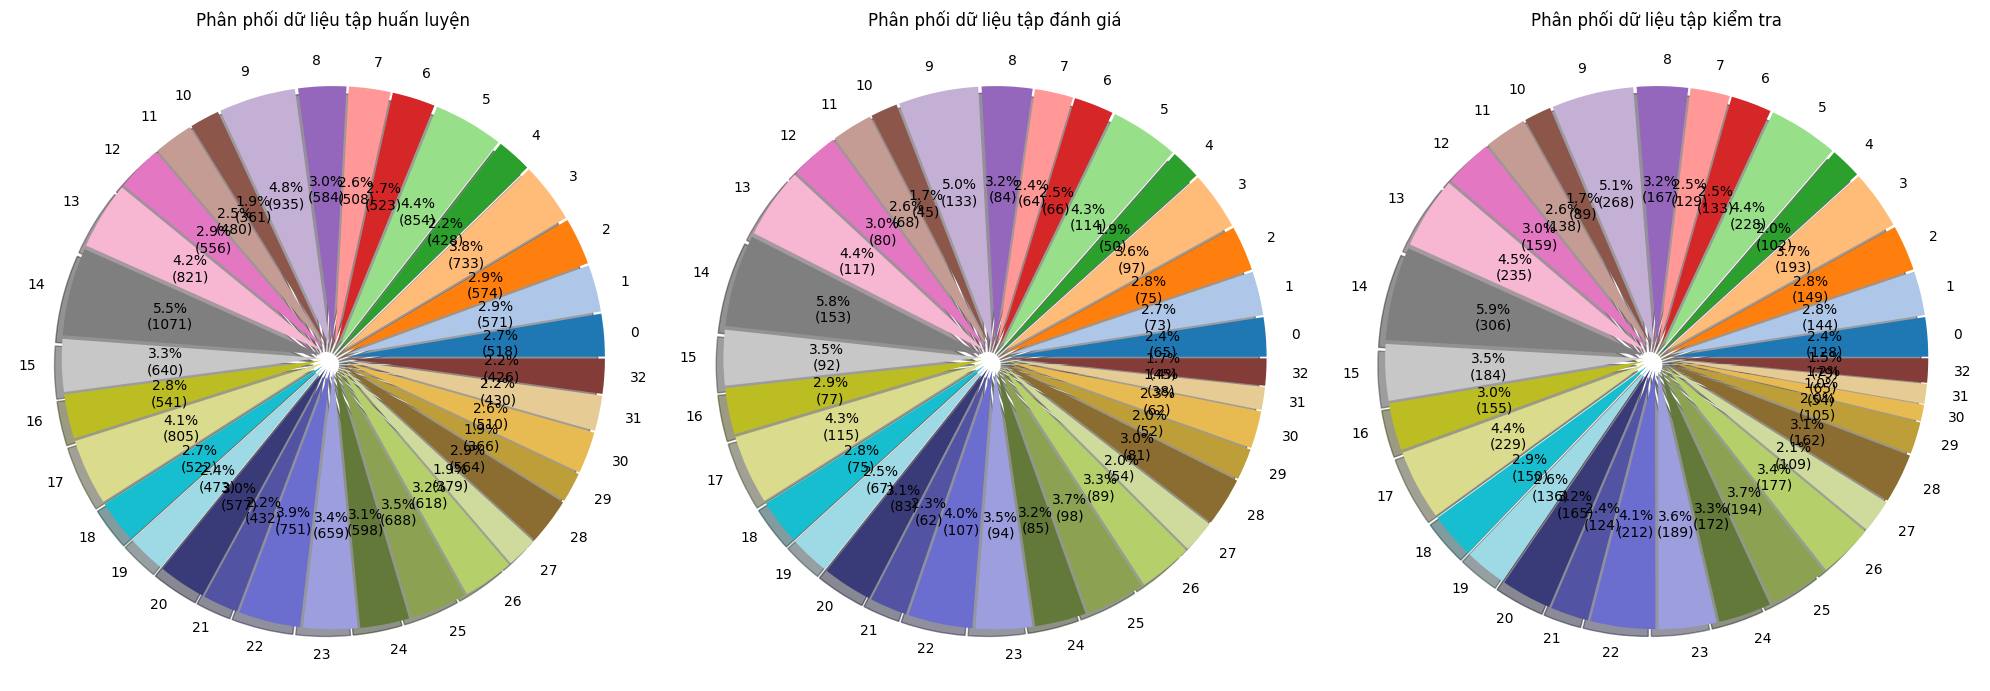

In [40]:
plot_compare_distributions(train_labels, val_labels, test_labels, Name_food)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24372\3367880263.py:76: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\Admin\AppData\Local\Temp\ipykernel_24372\3367880263.py:79: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path_table, dpi=300, bbox_inches="tight", facecolor="white")
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


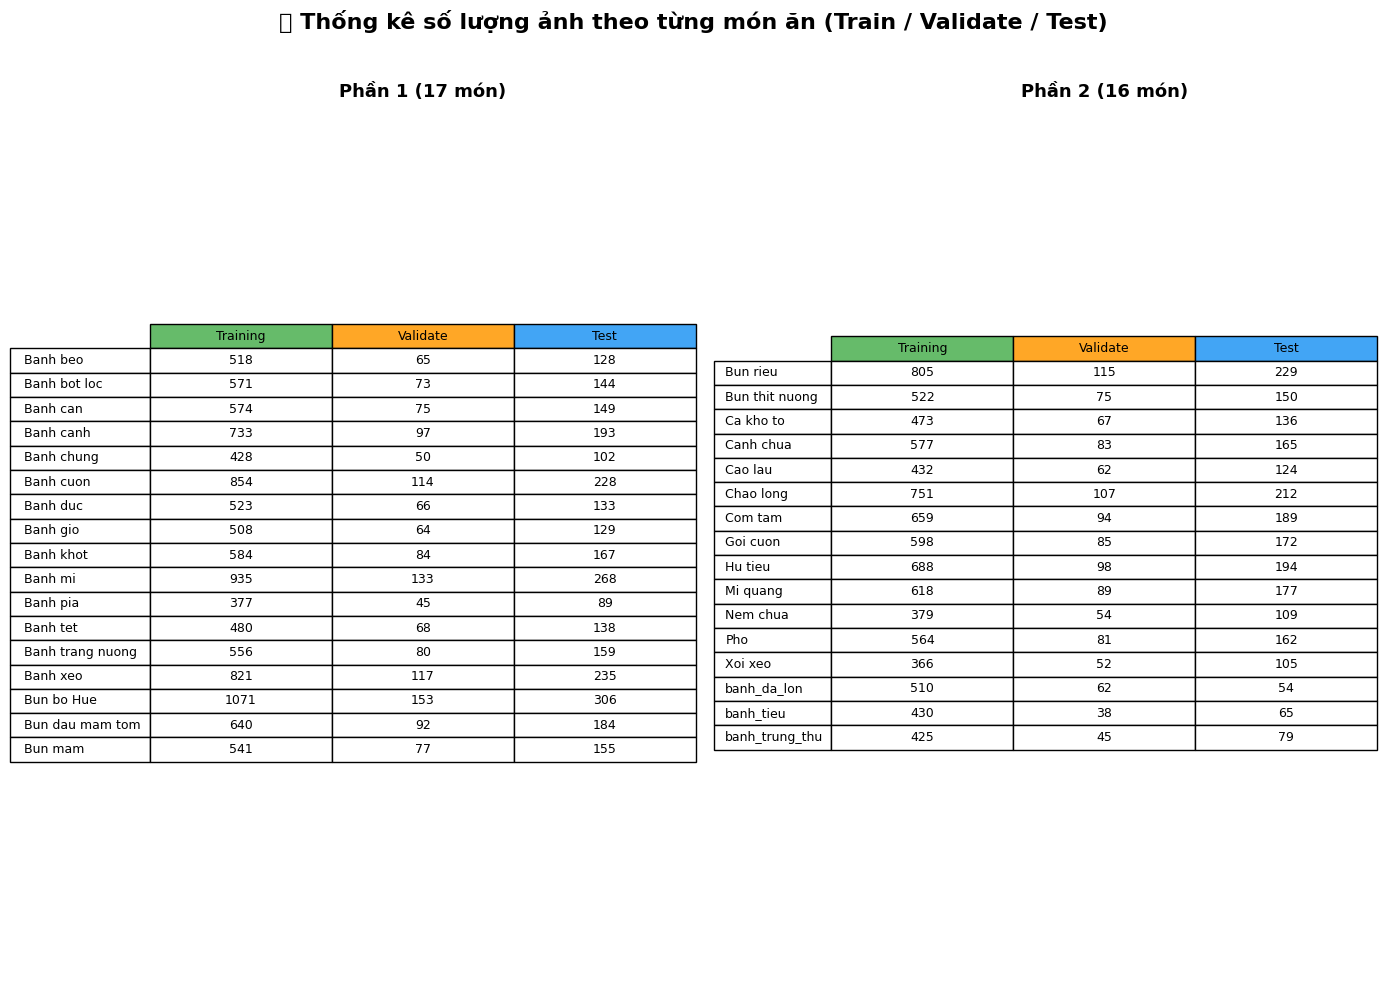

‚úÖ ƒê√£ l∆∞u h√¨nh b·∫£ng t·∫°i: ./images\dataset_table_2cols.png


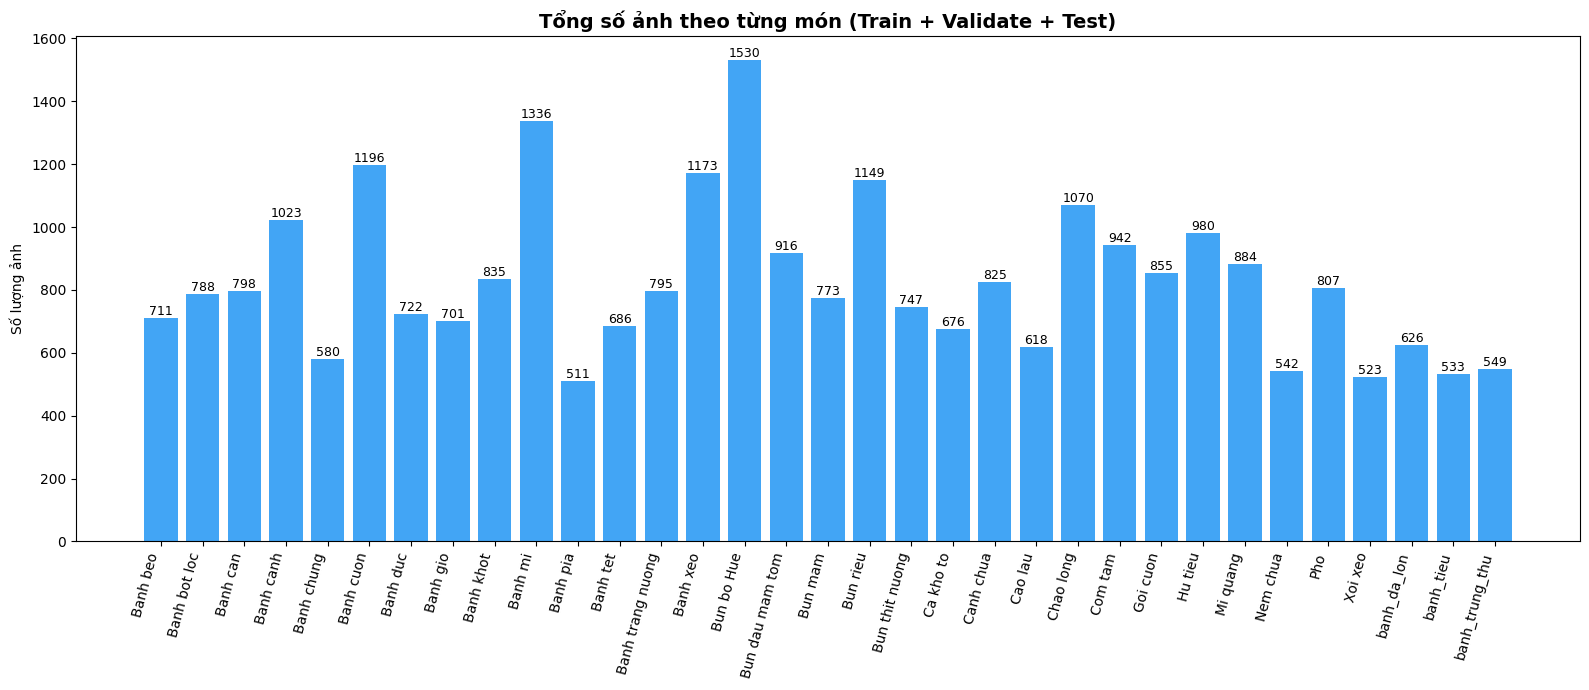

‚úÖ ƒê√£ l∆∞u h√¨nh bi·ªÉu ƒë·ªì t·∫°i: ./images\class_distribution_bar.png

üìå T·ªïng k·∫øt:
  - T·ªïng s·ªë l·ªõp     : 33
  - T·ªïng ·∫£nh Train   : 19511
  - T·ªïng ·∫£nh Validate: 2660
  - T·ªïng ·∫£nh Test    : 5229


In [43]:
# %% ƒê·∫øm ·∫£nh v√† hi·ªÉn th·ªã b·∫£ng th·ªëng k√™ Train / Validate / Test
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==== ƒê∆∞·ªùng d·∫´n d·ªØ li·ªáu ====
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"   # <== ƒë·ªïi n·∫øu c·∫ßn
root_train = f"{ROOT}/Train"
root_val   = f"{ROOT}/Validate"
root_test  = f"{ROOT}/Test"

SAVE_DIR = "./images"
os.makedirs(SAVE_DIR, exist_ok=True)

# ==== H√†m ƒë·∫øm s·ªë l∆∞·ª£ng ·∫£nh trong t·ª´ng l·ªõp ====
def count_images_by_class(folder):
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    counts = {}
    if not os.path.exists(folder):
        print(f"‚ö†Ô∏è Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c: {folder}")
        return counts
    for cls in sorted(os.listdir(folder)):
        path = os.path.join(folder, cls)
        if os.path.isdir(path):
            n = len([f for f in os.listdir(path) if f.lower().endswith(exts)])
            counts[cls] = n
    return counts

train_counts = count_images_by_class(root_train)
val_counts   = count_images_by_class(root_val)
test_counts  = count_images_by_class(root_test)

# ==== G·ªôp danh s√°ch l·ªõp ====
all_classes = sorted(set(train_counts) | set(val_counts) | set(test_counts))
df = pd.DataFrame({
    "Training": [train_counts.get(c, 0) for c in all_classes],
    "Validate": [val_counts.get(c, 0) for c in all_classes],
    "Test": [test_counts.get(c, 0) for c in all_classes],
}, index=all_classes)

# ==== Ki·ªÉm tra l·ªõp thi·∫øu ·∫£nh ·ªü t·∫≠p n√†o ====
for c in all_classes:
    missing = []
    if df.loc[c, "Training"] == 0: missing.append("Train")
    if df.loc[c, "Validate"] == 0: missing.append("Val")
    if df.loc[c, "Test"] == 0: missing.append("Test")
    if missing:
        print(f"‚ö†Ô∏è L·ªõp {c} thi·∫øu ·∫£nh ·ªü: {', '.join(missing)}")

# ==== Chia b·∫£ng th√†nh 2 ph·∫ßn (17 v√† 16 l·ªõp) ====
left_df  = df.iloc[:17]
right_df = df.iloc[17:]

# ==== Hi·ªÉn th·ªã b·∫£ng th·ªëng k√™ ====
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
fig.suptitle("üìä Th·ªëng k√™ s·ªë l∆∞·ª£ng ·∫£nh theo t·ª´ng m√≥n ƒÉn (Train / Validate / Test)", fontsize=16, fontweight='bold')

def draw_table(ax, sub_df, title):
    ax.axis("off")
    tbl = ax.table(
        cellText=sub_df.values,
        colLabels=sub_df.columns,
        rowLabels=sub_df.index,
        loc="center",
        cellLoc="center",
        colColours=["#66BB6A", "#FFA726", "#42A5F5"]
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.15, 1.3)
    ax.set_title(title, fontsize=13, pad=10, fontweight="bold")

draw_table(axes[0], left_df,  f"Ph·∫ßn 1 ({len(left_df)} m√≥n)")
draw_table(axes[1], right_df, f"Ph·∫ßn 2 ({len(right_df)} m√≥n)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

save_path_table = os.path.join(SAVE_DIR, "dataset_table_2cols.png")
plt.savefig(save_path_table, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"‚úÖ ƒê√£ l∆∞u h√¨nh b·∫£ng t·∫°i: {save_path_table}")

# ==== Bi·ªÉu ƒë·ªì c·ªôt t·ªïng s·ªë ·∫£nh ====
df["Total"] = df.sum(axis=1)
plt.figure(figsize=(16, 7))
bars = plt.bar(df.index, df["Total"], color="#42A5F5")
plt.title("T·ªïng s·ªë ·∫£nh theo t·ª´ng m√≥n (Train + Validate + Test)", fontsize=14, fontweight="bold")
plt.ylabel("S·ªë l∆∞·ª£ng ·∫£nh")
plt.xticks(rotation=75, ha="right")

for b in bars:
    v = int(b.get_height())
    if v > 0:
        plt.text(b.get_x() + b.get_width()/2, v, str(v), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
save_path_bar = os.path.join(SAVE_DIR, "class_distribution_bar.png")
plt.savefig(save_path_bar, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"‚úÖ ƒê√£ l∆∞u h√¨nh bi·ªÉu ƒë·ªì t·∫°i: {save_path_bar}")

# ==== T·ªïng k·∫øt ====
print("\nüìå T·ªïng k·∫øt:")
print(f"  - T·ªïng s·ªë l·ªõp     : {len(df)}")
print(f"  - T·ªïng ·∫£nh Train   : {int(df['Training'].sum())}")
print(f"  - T·ªïng ·∫£nh Validate: {int(df['Validate'].sum())}")
print(f"  - T·ªïng ·∫£nh Test    : {int(df['Test'].sum())}")


In [42]:
# B1) 2D Hist k√≠ch th∆∞·ªõc (w,h)
plt.figure(figsize=(6,5))
plt.hist2d(df["w"], df["h"], bins=40, cmap="Blues")
plt.colorbar(label="count")
plt.xlabel("width"); plt.ylabel("height")
plt.title("Resolution density (W vs H)")
plt.tight_layout(); plt.show()

# B2) Aspect ratio & area
fig, ax = plt.subplots(1,2, figsize=(11,4))
sns.histplot(df["aspect"].clip(0,5), bins=40, ax=ax[0])
ax[0].set_title("Aspect ratio (W/H)"); ax[0].set_xlabel("aspect (clipped ‚â§5)")
sns.histplot(np.log10(df["area"]+1), bins=40, ax=ax[1])
ax[1].set_title("log10(Area)")
plt.tight_layout(); plt.show()

# B3) ƒê·∫∑t c·ªù outlier
w_q1, w_q99 = df["w"].quantile([0.01, 0.99])
h_q1, h_q99 = df["h"].quantile([0.01, 0.99])
df["size_outlier"] = ((df["w"]<w_q1)|(df["w"]>w_q99)|(df["h"]<h_q1)|(df["h"]>h_q99))
print("·∫¢nh size outlier:", int(df["size_outlier"].sum()))


KeyError: 'w'

<Figure size 600x500 with 0 Axes>